# Introducing the Keras Sequential API

**Learning Objectives**
  1. Learn how to use feature columns in a Keras model
  1. Build a DNN model using the Keras Sequential API
  1. Learn how to train a model with Keras
  1. Learn how to save/load, and deploy a Keras model on GCP
  1. Learn how to deploy and make predictions with at Keras model

## Introduction

The [Keras sequential API](https://keras.io/models/sequential/) allows you to create Tensorflow models layer-by-layer. This is useful for building most kinds of machine learning models but it does not allow you to create models that share layers, re-use layers or have multiple inputs or outputs. 

In this lab, we'll see how to build a simple deep neural network model using the keras sequential api and feature columns. Once we have trained our model, we will deploy it using AI Platform and see how to call our model for online prediciton.


In [1]:
import datetime
import os
import shutil

import numpy as np
import pandas as pd
import tensorflow as tf

from matplotlib import pyplot as plt
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, DenseFeatures
from tensorflow.keras.callbacks import TensorBoard

print(tf.__version__)
%matplotlib inline

2.2.0


In [2]:
#Explore dataset
path = '../data/taxi-test.csv'

data = pd.read_csv(path, names=['fare_amount',
                                'pickup_datetime',
                                'pickup_longitude',
                                'pickup_latitude',
                                'dropoff_longitude',
                                'dropoff_latitude',
                                'passenger_count',
                                'key'])
data.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,key
0,6.0,2013-03-27 03:35:00 UTC,-73.977672,40.784052,-73.965332,40.801025,2,0
1,19.3,2012-05-10 18:43:16 UTC,-73.954366,40.778924,-74.004094,40.723104,1,1
2,7.5,2014-05-20 23:09:00 UTC,-73.999165,40.738377,-74.003473,40.723862,2,2
3,12.5,2015-02-23 19:51:31 UTC,-73.965210,40.769482,-73.989494,40.739742,1,3
4,10.9,2011-03-19 03:32:00 UTC,-73.992590,40.742957,-73.989908,40.711053,1,4


In [3]:
len(data)

1572

## Load raw data 

We will use the taxifare dataset, using the CSV files that we created in the first notebook of this sequence. Those files have been saved into `../data`.

In [4]:
CSV_COLUMNS = [
    'fare_amount',
    'pickup_datetime',
    'pickup_longitude',
    'pickup_latitude',
    'dropoff_longitude',
    'dropoff_latitude',
    'passenger_count',
    'key'
]
LABEL_COLUMN = 'fare_amount'
DEFAULTS = [[0.0], ['na'], [0.0], [0.0], [0.0], [0.0], [0.0], ['na']]
UNWANTED_COLS = ['pickup_datetime', 'key']


def features_and_labels(row_data):
    label = row_data.pop(LABEL_COLUMN)
    features = row_data
    
    for unwanted_col in UNWANTED_COLS:
        features.pop(unwanted_col)

    return features, label


def create_dataset(pattern, batch_size=1, mode='eval'):
    dataset = tf.data.experimental.make_csv_dataset(
        pattern, batch_size, CSV_COLUMNS, DEFAULTS)

    dataset = dataset.map(features_and_labels)

    if mode == 'train':
        dataset = dataset.shuffle(buffer_size=1000).repeat()

    # take advantage of multi-threading; 1=AUTOTUNE
    dataset = dataset.prefetch(1)
    return dataset

## Build a simple keras DNN model

We will use feature columns to connect our raw data to our keras DNN model. Feature columns make it easy to perform common types of feature engineering on your raw data. For example, you can one-hot encode categorical data, create feature crosses, embeddings and more. We'll cover these in more detail later in the course, but if you want to a sneak peak browse the official TensorFlow [feature columns guide](https://www.tensorflow.org/guide/feature_columns).

In our case we won't do any feature engineering. However, we still need to create a list of feature columns to specify the numeric values which will be passed on to our model. To do this, we use `tf.feature_column.numeric_column()`

We use a python dictionary comprehension to create the feature columns for our model, which is just an elegant alternative to a for loop.

In [5]:
INPUT_COLS = [
    'pickup_longitude',
    'pickup_latitude',
    'dropoff_longitude',
    'dropoff_latitude',
    'passenger_count',
]

# Create input layer of feature columns
# TODO 1
feature_columns = {header: tf.feature_column.numeric_column(header) for header in INPUT_COLS}

Next, we create the DNN model. The Sequential model is a linear stack of layers and when building a model using the Sequential API, you configure each layer of the model in turn. Once all the layers have been added, you compile the model. 

**Lab Task #2a:** Create a deep neural network using Keras's Sequential API. In the cell below, use the `tf.keras.layers` library to create all the layers for your deep neural network. 

In [6]:
# Build a keras DNN model using Sequential API
model = Sequential([
    DenseFeatures(feature_columns=feature_columns.values()),
    Dense(32, activation="relu", name="h1"),
    Dense(units=8, activation="relu", name="h2"),
    Dense(units=1, activation="linear", name="output")
])

Next, to prepare the model for training, you must configure the learning process. This is done using the compile method. The compile method takes three arguments:

* An optimizer. This could be the string identifier of an existing optimizer (such as `rmsprop` or `adagrad`), or an instance of the [Optimizer class](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/optimizers).
* A loss function. This is the objective that the model will try to minimize. It can be the string identifier of an existing loss function from the [Losses class](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/losses) (such as categorical_crossentropy or mse), or it can be a custom objective function.
* A list of metrics. For any machine learning problem you will want a set of metrics to evaluate your model. A metric could be the string identifier of an existing metric or a custom metric function.

We will add an additional custom metric called `rmse` to our list of metrics which will return the root mean square error. 

In [7]:
# TODO 2b
# Create a custom evalution metric
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))


# Compile the keras model
model.compile(optimizer="adam",
             loss="mse",
             metrics=["mse", rmse])

## Train the model

To train your model, Keras provides three functions that can be used:
 1. `.fit()` for training a model for a fixed number of epochs (iterations on a dataset).
 2. `.fit_generator()` for training a model on data yielded batch-by-batch by a generator
 3. `.train_on_batch()` runs a single gradient update on a single batch of data. 
 
The `.fit()` function works well for small datasets which can fit entirely in memory. However, for large datasets (or if you need to manipulate the training data on the fly via data augmentation, etc) you will need to use `.fit_generator()` instead. The `.train_on_batch()` method is for more fine-grained control over training and accepts only a single batch of data.

The taxifare dataset we sampled is small enough to fit in memory, so can we could use `.fit` to train our model. Our `create_dataset` function above generates batches of training examples, so we could also use `.fit_generator`. In fact, when calling `.fit` the method inspects the data, and if it's a generator (as our dataset is) it will invoke automatically `.fit_generator` for training. 

We start by setting up some parameters for our training job and create the data generators for the training and validation data.

We refer you the the blog post [ML Design Pattern #3: Virtual Epochs](https://medium.com/google-cloud/ml-design-pattern-3-virtual-epochs-f842296de730) for further details on why express the training in terms of `NUM_TRAIN_EXAMPLES` and `NUM_EVALS` and why, in this training code, the number of epochs is really equal to the number of evaluations we perform.

In [8]:
TRAIN_BATCH_SIZE = 1000
NUM_TRAIN_EXAMPLES = 10000 * 5  # training dataset will repeat, wrap around
NUM_EVALS = 50  # how many times to evaluate
NUM_EVAL_EXAMPLES = 10000  # enough to get a reasonable sample

trainds = create_dataset(
    pattern='../data/taxi-train*',
    batch_size=TRAIN_BATCH_SIZE,
    mode='train')

evalds = create_dataset(
    pattern='../data/taxi-valid*',
    batch_size=1000,
    mode='eval').take(NUM_EVAL_EXAMPLES//1000)

There are various arguments you can set when calling the [.fit method](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/Model#fit). Here `x` specifies the input data which in our case is a `tf.data` dataset returning a tuple of (inputs, targets). The `steps_per_epoch` parameter is used to mark the end of training for a single epoch. Here we are training for NUM_EVALS epochs. Lastly, for the `callback` argument we specify a Tensorboard callback so we can inspect Tensorboard after training. 

**Lab Task #3:** In the cell below, you will train your model. First, define the `steps_per_epoch` then train your model using `.fit()`, saving the model training output to a variable called `history`.

In [9]:
# TODO 3
%time 
steps_per_epoch = NUM_TRAIN_EXAMPLES // (TRAIN_BATCH_SIZE * NUM_EVALS)

LOGDIR = "./taxi_trained"
history = model.fit(trainds,
                    steps_per_epoch=steps_per_epoch,
                    epochs=NUM_EVALS,
                    validation_data=evalds,
                    callbacks=[TensorBoard(LOGDIR)])

Wall time: 0 ns
Epoch 1/50
1/1 [==============================] - 0s 303ms/step - loss: 204.7796 - mse: 204.7796 - rmse: 14.3101 - val_loss: 156.2522 - val_mse: 156.2522 - val_rmse: 12.4904
Epoch 2/50
1/1 [==============================] - 0s 126ms/step - loss: 144.3576 - mse: 144.3576 - rmse: 12.0149 - val_loss: 135.7044 - val_mse: 135.7044 - val_rmse: 11.6457
Epoch 3/50
1/1 [==============================] - 0s 140ms/step - loss: 115.8951 - mse: 115.8951 - rmse: 10.7655 - val_loss: 122.0909 - val_mse: 122.0909 - val_rmse: 11.0463
Epoch 4/50
1/1 [==============================] - 0s 127ms/step - loss: 108.8609 - mse: 108.8609 - rmse: 10.4336 - val_loss: 115.7140 - val_mse: 115.7140 - val_rmse: 10.7333
Epoch 5/50
1/1 [==============================] - 0s 127ms/step - loss: 104.5768 - mse: 104.5768 - rmse: 10.2263 - val_loss: 111.7310 - val_mse: 111.7310 - val_rmse: 10.5608
Epoch 6/50
1/1 [==============================] - 0s 129ms/step - loss: 101.3176 - mse: 101.3176 - rmse: 10.0657 -

### High-level model evaluation

Once we've run data through the model, we can call `.summary()` on the model to get a high-level summary of our network. We can also plot the training and evaluation curves for the metrics we computed above. 

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_features (DenseFeature multiple                  0         
_________________________________________________________________
h1 (Dense)                   multiple                  192       
_________________________________________________________________
h2 (Dense)                   multiple                  264       
_________________________________________________________________
output (Dense)               multiple                  9         
Total params: 465
Trainable params: 465
Non-trainable params: 0
_________________________________________________________________


Running `.fit` (or `.fit_generator`) returns a History object which collects all the events recorded during training. Similar to Tensorboard, we can plot the training and validation curves for the model loss and rmse by accessing these elements of the History object.

<AxesSubplot:>

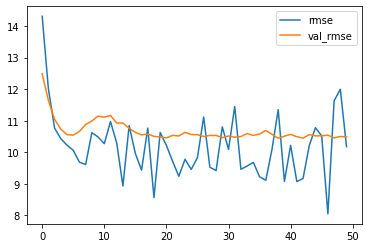

In [13]:
RMSE_COLS = ['rmse', 'val_rmse']

pd.DataFrame(history.history)[RMSE_COLS].plot()

<AxesSubplot:>

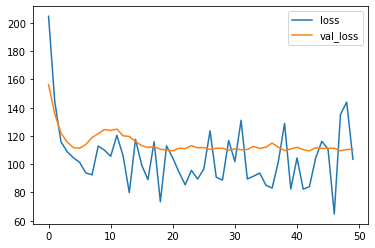

In [14]:
LOSS_COLS = ['loss', 'val_loss']

pd.DataFrame(history.history)[LOSS_COLS].plot()

# Making predictions with our model

To make predictions with our trained model, we can call the [predict method](https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict), passing to it a dictionary of values. The `steps` parameter determines the total number of steps before declaring the prediction round finished. Here since we have just one example, we set `steps=1` (setting `steps=None` would also work). Note, however, that if x is a `tf.data` dataset or a dataset iterator, and steps is set to None, predict will run until the input dataset is exhausted.

In [15]:
model.predict(x={"pickup_longitude": tf.convert_to_tensor([-73.982683]),
                 "pickup_latitude": tf.convert_to_tensor([40.742104]),
                 "dropoff_longitude": tf.convert_to_tensor([-73.983766]),
                 "dropoff_latitude": tf.convert_to_tensor([40.755174]),
                 "passenger_count": tf.convert_to_tensor([3.0])},
              steps=1)

array([[11.692491]], dtype=float32)

# Export and deploy our model

Of course, making individual predictions is not realistic, because we can't expect client code to have a model object in memory. For others to use our trained model, we'll have to export our model to a file, and expect client code to instantiate the model from that exported file. 

We'll export the model to a TensorFlow SavedModel format. Once we have a model in this format, we have lots of ways to "serve" the model, from a web application, from JavaScript, from mobile applications, etc.

In [16]:
# TODO 4a
OUTPUT_DIR = "./export/savedmodel"
shutil.rmtree(OUTPUT_DIR, ignore_errors=True)
EXPORT_PATH = os.path.join(OUTPUT_DIR,
                           datetime.datetime.now().strftime("%Y%m%d%H%M%S"))
tf.saved_model.save(model, EXPORT_PATH)  # with default serving function

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./export/savedmodel\20200920194145\assets


In [57]:
# TODO 4b
!saved_model_cli show \
 --tag_set serve \
 --signature_def serving_default \
 --dir {EXPORT_PATH}
!find {EXPORT_PATH}
os.environ['EXPORT_PATH'] = EXPORT_PATH

2020-09-20 16:02:02.400453: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'cudart64_101.dll'; dlerror: cudart64_101.dll not found
2020-09-20 16:02:02.400650: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


The given SavedModel SignatureDef contains the following input(s):
  inputs['dropoff_latitude'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: serving_default_dropoff_latitude:0
  inputs['dropoff_longitude'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: serving_default_dropoff_longitude:0
  inputs['passenger_count'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: serving_default_passenger_count:0
  inputs['pickup_latitude'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: serving_default_pickup_latitude:0
  inputs['pickup_longitude'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: serving_default_pickup_longitude:0
The given SavedModel SignatureDef contains the following output(s):
  outputs['output_1'] tensor_info:
      dtype: DT_FLOAT
      shape: (-1, 1)
      name: StatefulPartitionedCall:0
Method name is: tensorflow/serving/predict


FIND: Parameter format not correct


### Deploy our model to AI Platform

Finally, we will deploy our trained model to AI Platform and see how we can make online predicitons. 

In [ ]:
%%bash

# TODO 5a

PROJECT= # TODO: Change this to your PROJECT
BUCKET=${PROJECT}
REGION=us-east1
MODEL_NAME=taxifare
VERSION_NAME=dnn

## Create GCS bucket if it doesn't exist already...
exists=$(gsutil ls -d | grep -w gs://${BUCKET}/)

if [ -n "$exists" ]; then
    echo -e "Bucket exists, let's not recreate it."
else
    echo "Creating a new GCS bucket."
    gsutil mb -l ${REGION} gs://${BUCKET}
    echo "\nHere are your current buckets:"
    gsutil ls
fi

if [[ $(gcloud ai-platform models list --format='value(name)' | grep $MODEL_NAME) ]]; then
    echo "$MODEL_NAME already exists"
else
    echo "Creating $MODEL_NAME"
    gcloud ai-platform models create --regions=$REGION $MODEL_NAME
fi

if [[ $(gcloud ai-platform versions list --model $MODEL_NAME --format='value(name)' | grep $VERSION_NAME) ]]; then
    echo "Deleting already existing $MODEL_NAME:$VERSION_NAME ... "
    echo yes | gcloud ai-platform versions delete --model=$MODEL_NAME $VERSION_NAME
    echo "Please run this cell again if you don't see a Creating message ... "
    sleep 2
fi

echo "Creating $MODEL_NAME:$VERSION_NAME"
gcloud ai-platform versions create --model=$MODEL_NAME $VERSION_NAME \
       --framework=tensorflow --python-version=3.7 --runtime-version=2.1 \
       --origin=$EXPORT_PATH --staging-bucket=gs://$BUCKET

In [ ]:
%%writefile input.json
{"pickup_longitude": -73.982683, "pickup_latitude": 40.742104,"dropoff_longitude": -73.983766,"dropoff_latitude": 40.755174,"passenger_count": 3.0}  

In [ ]:
# TODO 5b
!gcloud ai-platform predict --model taxifare --json-instances input.json --version dnn